<a href="https://colab.research.google.com/github/csengAIDA/MyFirstRepo/blob/master/Project_Week_7_Global_Warming_Team_B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mission 1:
Take an objective, neutral, and data-driven stance to the 4 pillars of the climate-sceptic arguments: there is no change, we aren’t causing the change, the evidence is not definitive.

Average Temperatures in major cities:
https://raw.githubusercontent.com/mbhatti29/Climate-Change-and-Sea-Level/master/Data/GlobalLandTemperaturesByMajorCity.csv


## Import Libraries

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
# ignore the SettingWithCopyException warning
pd.set_option("chained_assignment", None)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score


## Define Functions

In [ ]:
# Function to gain insights into DataFrames
def df_investigate(df):
  info = pd.DataFrame(df.count(), columns=['filled'])
  info['filled %'] = round(info['filled'] / len(df), 4)*100
  info['nunique'] = df.nunique()
  info['uniques'] = np.nan
  info['dtypes'] = df.dtypes
  for idx, row in info.iterrows():
    if row['nunique'] < 10:
      info.loc[idx, 'uniques'] = str(list(df[idx].unique()))
  return info


# Function to filter data on specified properties 
def filter_data(df, country, start_date, group, value_column):
  selected_by_year = df[df["Year"] > start_date]
  result = selected_by_year[["Year","Country"]]
  idx = pd.IndexSlice
  result[value_column] = selected_by_year.loc[:,idx[group,value_column]]
  return result


# Function to filter data on specified properties
def filter_data_ext(df, value_column, group, country=None, start_date=None, end_date=None):
    """Select aggregated value from data frame.

    Keyword arguments:
      df:  data frame with values
      value_column: name of aggregated value column, requires also group name
      group: defines multi index group name for aggregates values    
      country:  single str as country name, if None return all countries    
      start_date: starting date(included), if None returns all
    Return:
      data frame: with following columns - year and one or more aggregated value 
        from desired groupo, ignores NaNs
    """
  
    # preprocess data, convert years to number
    df['Year'] = pd.to_numeric(df['Year'], downcast='signed')
    
    # check by start year
    if start_date != None:
      selected_by_year = df[(df["Year"] >= start_date) & (df["Year"] < end_date)]
    else:
      selected_by_year = df

    # remove NaNs
    selected_by_year = selected_by_year.copy().dropna()  
    
    # select by country
    if country != None:
      # list of countrie
      if isinstance(country,list):
        selected_by_country = selected_by_year[selected_by_year["Country"].isin(country)] 
      else:
        # one country
        selected_by_country = selected_by_year[selected_by_year["Country"] == country]   
      
      selected_tmp = selected_by_country[["Year",group]]
    else:
      # all countries
      selected_tmp = selected_by_year[["Year",group]]

    all_aggr =  selected_tmp.groupby(["Year"])[group].agg(value_column).reset_index()
    all_aggr.rename(columns={group:value_column}, inplace = True)
   
    return all_aggr



def calc_linear_coeficient(df, regressed_col):
  """Calc linerar regression parameter for given data set.

    Keyword arguments:
    df -- data frame
    explanatory -- name of explanatory column
    dependent -- name of dependent column to be predicted

    Return:
      tuple with (coef , intercept) values
  """
  X = df[["Year"]]
  y = df[regressed_col]
 
  # To train a machine learning model (here, it will find the equation of the linear regression), you just have launch the ".fit" method.
  regressor = LinearRegression()
  modelLR = regressor.fit(X, y)
  return (modelLR.coef_[0], modelLR.intercept_, 1)



def calc_linear_coeficient_ext(df, regressed_col):
  """Calc linerar regression parameter for given data set with train/test set and check quality.
     

    Keyword arguments:
    df -- data frame
    regressed_col -- name of dependent column

    Return:
      tuple with (coef , intercept, R2 quality) values
  """
  X = df[["Year"]]
  y = df[regressed_col]

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
 
  # To train a machine learning model (here, it will find the equation of the linear regression), you just have launch the ".fit" method.
  regressor = LinearRegression()
  modelLR = regressor.fit(X_train, y_train)

  score_X = X_test
  score_y = y_test
  score = modelLR.score(score_X,score_y) 
  
  return (modelLR.coef_[0], modelLR.intercept_, score)  



# Function to filter Data on Quality (#NaN's and AUncertainty)
def filter_uncertains( df_all, window_null, count_null_tolerance, window_uncertainity, uncertainity_tolerance) :

  df_StartYears = pd.DataFrame(columns=['StartYear', 'Country'])
  country_list = df_all['Country'].unique()

  for country in country_list :

    start_year = 2020
    df_country = df_all[ df_all['Country'] == country ]
    df_country['CountNotNaN'] = df_country[('AverageTemperature','mean')].rolling(window_null, center=True).count()

    df_country['Avg_Mean'] = df_country[('AverageTemperature','mean')].rolling(window_uncertainity, center=True).mean()
    df_country['Unc_Mean'] = df_country[('AverageTemperatureUncertainty','mean')].rolling(window_uncertainity, center=True).mean()

    found_not_NaN = False

    for index, row in df_country.iterrows():

      if found_not_NaN == False :

        count = row['CountNotNaN'][0]
        if( count > 0) :
          if( count/window_null >= count_null_tolerance) :
            start_year = row['Year'][0]
            found_not_NaN = True

      if found_not_NaN == True :
        mean_temp = row['Avg_Mean'][0]
        uncr_temp = row['Unc_Mean'][0]

        if( uncr_temp > 0) :
          unc_fact = uncr_temp/mean_temp

          # !!!   If error still too much, than shift the start_year up   !!!
          if( unc_fact >= uncertainity_tolerance ) :
            start_year = row['Year'][0]
#            print(" shift up ----------> start_year=" , start_year)
#            print(" shift up ----------> country=" , country)

    new_row = { 'StartYear': start_year,  'Country': country}
    df_StartYears = df_StartYears.append( new_row, ignore_index=True)

  return df_StartYears

## Data Preprocessing

### Load and Display Temperature Data

In [ ]:
url ='https://raw.githubusercontent.com/mbhatti29/Climate-Change-and-Sea-Level/master/Data/GlobalLandTemperaturesByMajorCity.csv'
df_temp = pd.read_csv(url)
display(df_temp.head(3), df_temp.tail(3))
display(df_investigate(df_temp))

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W
1,1849-02-01,27.434,1.362,Abidjan,Côte D'Ivoire,5.63N,3.23W
2,1849-03-01,28.101,1.612,Abidjan,Côte D'Ivoire,5.63N,3.23W


,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
239174,2013-07-01,25.251,1.042,Xian,China,34.56N,108.97E
239175,2013-08-01,24.528,0.840,Xian,China,34.56N,108.97E
239176,2013-09-01,NaN,NaN,Xian,China,34.56N,108.97E


,filled,filled %,nunique,uniques,dtypes
dt,239177,100.0,3239,NaN,object
AverageTemperature,228175,95.4,56348,NaN,float64
AverageTemperatureUncertainty,228175,95.4,6269,NaN,float64
City,239177,100.0,100,NaN,object
Country,239177,100.0,49,NaN,object
Latitude,239177,100.0,49,NaN,object
Longitude,239177,100.0,93,NaN,object


### Aggregate Data by Country and Year

Aggretion of data on Year and Country should be sufficient for a two day project.

In [ ]:
# create YEAR column
df_temp["Year"] = df_temp["dt"].str[0:4]

#aggregate data
df_temp_aggr = df_temp.groupby(["Year","Country"])["AverageTemperature","AverageTemperatureUncertainty"].agg([min, max, 'mean', 'median', 'std']).reset_index()
df_temp_aggr['Year'] = pd.to_numeric(df_temp_aggr['Year'], downcast='signed')
display(df_temp_aggr.head(3), df_temp_aggr.tail(3))

Year  Country AverageTemperature         ... AverageTemperatureUncertainty                          
                                min    max  ...                           max    mean  median       std
0  1743   Canada             -1.854 -0.106  ...                         1.905  1.8195  1.8195  0.120915
1  1743   France              7.648  7.648  ...                         1.749  1.7490  1.7490       NaN
2  1743  Germany              6.326  6.326  ...                         1.601  1.6010  1.6010       NaN

[3 rows x 12 columns]

Year        Country AverageTemperature  ... AverageTemperatureUncertainty                  
                                         min  ...                          mean  median       std
9803  2013  United States             -1.365  ...                      0.489926  0.3840  0.248624
9804  2013        Vietnam             26.597  ...                      0.466750  0.4035  0.209820
9805  2013       Zimbabwe             16.299  ...                      0.775250  0.6635  0.313592

[3 rows x 12 columns]

### Check Data Quality


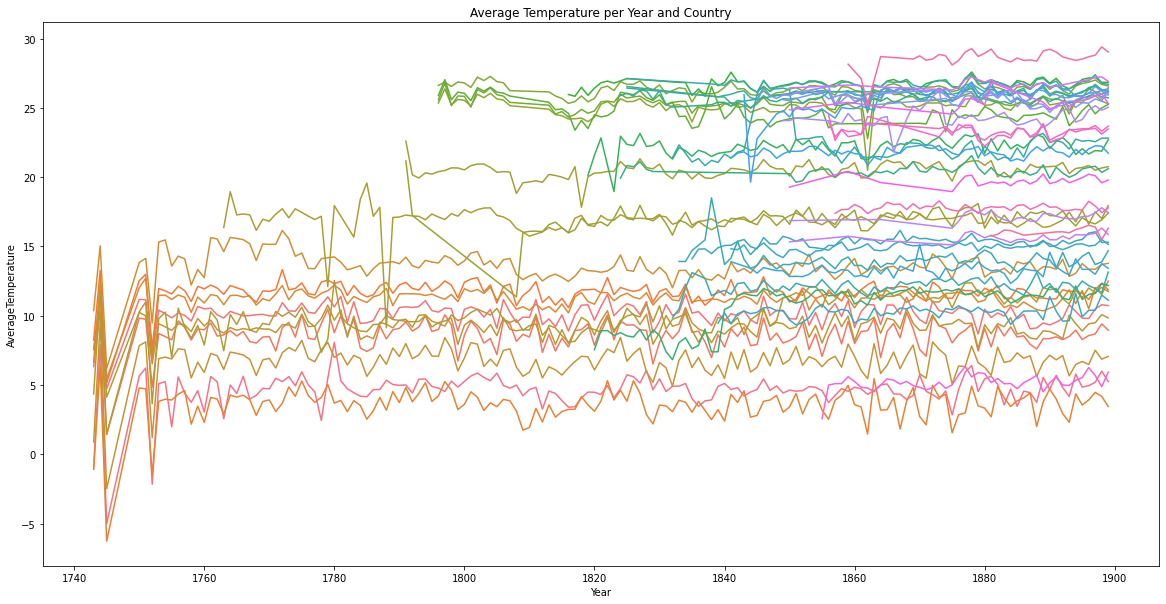

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
buffer = df_temp.groupby(["Year",'Country'])["AverageTemperature"].mean().reset_index()
buffer['Year'] = pd.to_numeric(buffer['Year'], downcast='signed')
sns.lineplot(data=buffer[buffer.Year < 1900], x='Year', y='AverageTemperature', hue='Country')
ax.get_legend().remove()
plt.title('Average Temperature per Year and Country')
plt.show()

**We can see (1):**

Data for most of the countries is available after 1850.

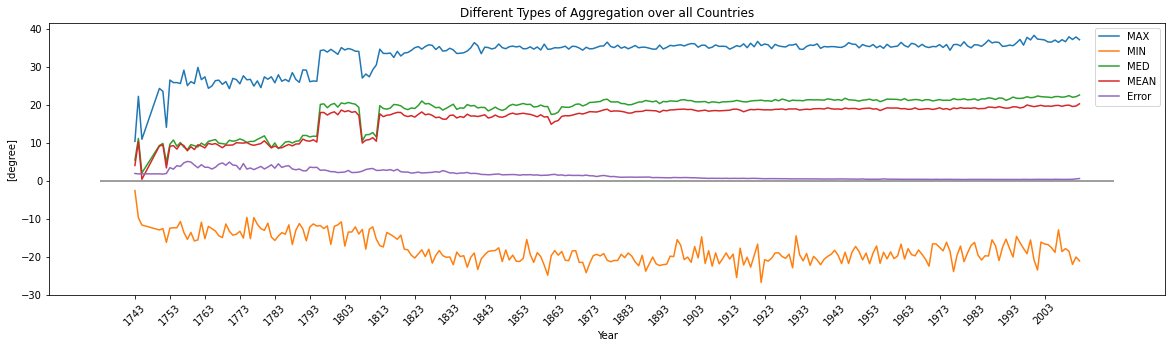

In [ ]:
# get global temperature values (ignore Country column) 
df_temp_year_global = df_temp.groupby("Year")["AverageTemperature","AverageTemperatureUncertainty"].agg([min, max, 'mean', 'median', 'std']).reset_index()
# convert Year column to INT
df_temp_year_global['Year'] = pd.to_numeric(df_temp_year_global['Year'], downcast='signed')

# plot data
fig, ax = plt.subplots(figsize=(20,5))
sns.lineplot(data=df_temp_year_global, x='Year', y=('AverageTemperature','max'), label='MAX')
sns.lineplot(data=df_temp_year_global, x='Year', y=('AverageTemperature','min'), label='MIN')
sns.lineplot(data=df_temp_year_global, x='Year', y=('AverageTemperature','median'), label='MED')
sns.lineplot(data=df_temp_year_global, x='Year', y=('AverageTemperature','mean'), label='MEAN')
sns.lineplot(data=df_temp_year_global, x='Year', y=('AverageTemperatureUncertainty','mean'), label='Error')
plt.xticks(np.arange(df_temp_year_global.Year.min(), df_temp_year_global.Year.max(), step=10), rotation=45)
plt.ylabel('[degree]')
plt.hlines(y=0, xmin=df_temp_year_global.Year.min()-10, xmax=df_temp_year_global.Year.max()+10,colors='grey')
plt.title('Different Types of Aggregation over all Countries')
plt.show()

**We can see (2):**

* The Uncertainty ('Error', violet in plot) in early years is very high
* The measured values seem some kind of volatile and less reliable in these years

In [ ]:
# find NaN values in original data
df_NaN_year_global = df_temp[['Year', 'AverageTemperature']].copy()

df_NaN_year_global['NaNs'] = df_NaN_year_global.isnull().sum(axis=1)
df_NaN_year_global = pd.DataFrame(df_NaN_year_global.groupby('Year')['NaNs'].sum(), columns=['NaNs']).reset_index()
df_NaN_year_global['Year'] = pd.to_numeric(df_NaN_year_global['Year'], downcast='signed')

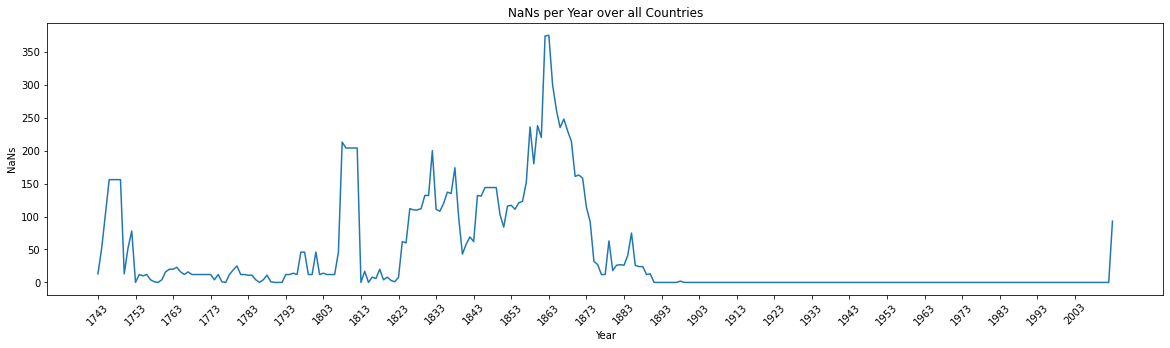

In [ ]:
# plot NaN occurence
fig, ax = plt.subplots(figsize=(20,5))
sns.lineplot(data=df_NaN_year_global, x='Year', y=('NaNs'))
plt.xticks(np.arange(df_NaN_year_global.Year.min(), df_NaN_year_global.Year.max(), step=10), rotation=45)
plt.ylabel('NaNs')
plt.title('NaNs per Year over all Countries')
plt.show()

**We can see (3):**

* A lot of missing values in early years. 
* Some missing values in last year.


**Conclusion:**
* To gain high quality data, find out, how data has to be filtered by 
** Date 
** and Country 


### Find Thresholds
for year, when data is realiable
 * threshold for number of NaN's
 * threshold for Uncertainty
 * metric: Uncertainty / Moving Delta (max-min in slice) 

**result**: first year per Country 

**decision**: How hast to data to be filtered to go on with reliable data?

 

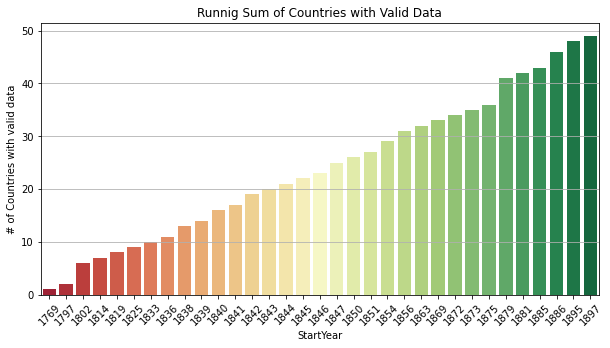

In [ ]:
# set test parameter
window_null = 12
count_null_tolerance = 1
window_uncertainity = 12
uncertainity_tolerance = 0.2

# run test
dfy = filter_uncertains(df_temp_aggr, window_null, count_null_tolerance, window_uncertainity,uncertainity_tolerance)
#dfy
to_plot = pd.DataFrame(dfy.groupby('StartYear').size().cumsum(), columns=['CumSum']).reset_index()

fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(data=to_plot, x='StartYear', y='CumSum', palette='RdYlGn')
#plt.axvline( 26.5, color='red', linewidth=3)
plt.ylabel('# of Countries with valid data')
plt.xticks(rotation=45)   # rotate x labels
ax.yaxis.grid()           # horizontal lines
plt.title('Runnig Sum of Countries with Valid Data')
plt.show()

### Define Threshold

In [ ]:
year_to_cut_off = 1879

# get resulting list of valid countries
dfy.set_index('Country', inplace=True)
valid_countries = dfy[dfy.StartYear<=year_to_cut_off].index
invalid_countries = dfy[dfy.StartYear>year_to_cut_off].index


# display countries, which are not taken into account
display(dfy[dfy.StartYear>year_to_cut_off])

,StartYear
Country,
Russia,1885
Ethiopia,1886
Kenya,1886
Somalia,1886
Tanzania,1895
Zimbabwe,1881
Chile,1895
Peru,1897


**Decision:**

Choose 1879 as year with valid data.
In case you would like to habe Russia as a huge country within the analyses, change threshold to 1885.

### Geo Visualization

Let's see, if our data is still distributed all over the world, so that we don't proceed with biased data

In [ ]:
# GeoPandas in Colab requires specific installation of cartopy, so install that BEFORE GeoPandas!
!apt-get -qq install python-cartopy python3-cartopy;
!pip install geopandas
!pip install geoplot

In [ ]:
# replace known differences in country names
dic = {'Burma': 'Myanmar',
       'Congo (Democratic Republic Of The)':'Congo', 
       'Singapore': 'Malaysia',                       # don't know what the alternative would be
       "Côte D'Ivoire": "Côte d'Ivoire", 
       'Dominican Republic':'Dominican Rep.',
       'United States':'United States of America'}
  
# create list of countries to keep for plotting in map
green_list = valid_countries.tolist()
for index, data in enumerate(green_list):
    for key, value in dic.items():
        if key in data:
            green_list[index]=data.replace(key, dic[key])

# create list of countries to drop for plotting in map
red_list = invalid_countries.tolist()
for index, data in enumerate(red_list):
    for key, value in dic.items():
        if key in data:
            red_list[index]=data.replace(key, dic[key])


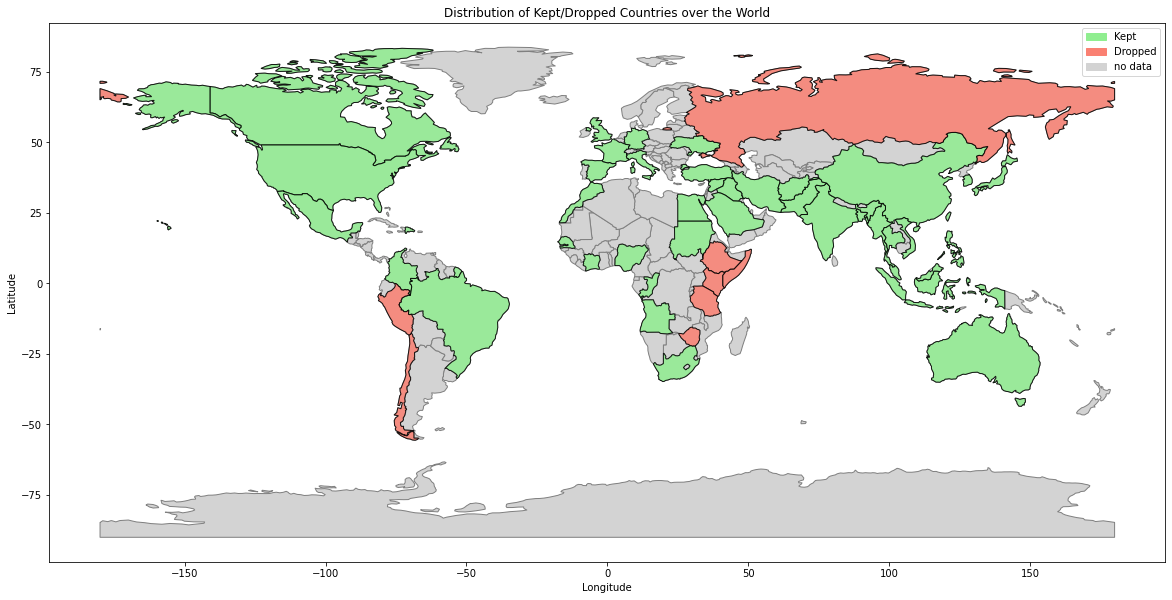

In [ ]:
import geopandas as gpd
from descartes import PolygonPatch

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

def plotCountryPatch( axes, country_name, fcolor ):
    # plot a country on the provided axes
    nami = world[world.name == country_name]
    namigm = nami.__geo_interface__['features']  # geopandas's geo_interface
    namig0 = {'type': namigm[0]['geometry']['type'], \
              'coordinates': namigm[0]['geometry']['coordinates']}
    axes.add_patch(PolygonPatch( namig0, fc=fcolor, ec="black", alpha=0.85, zorder=2 ))

# plot the whole world
ax2 = world.plot( figsize=(20,10), edgecolor=u'gray', color='lightgray' )


# then plot some countries on top
for i in green_list:
  plotCountryPatch(ax2, i, 'lightgreen')

for i in red_list:
  plotCountryPatch(ax2, i, 'salmon')

# the place to plot additional vector data (points, lines)

plt.ylabel('Latitude')
plt.xlabel('Longitude')

import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='salmon', label='Dropped')
green_patch = mpatches.Patch(color='lightgreen', label='Kept')
gray_patch = mpatches.Patch(color='lightgray', label='no data')
plt.legend(handles=[green_patch,red_patch,gray_patch],loc='upper right')

#ax2.axis('scaled')
plt.title('Distribution of Kept/Dropped Countries over the World')
plt.show()

**Interpretation**

We still have data from countries from all over the world. So hopefully no bias due to data cleaning.

### Keep DateFrame with Valid Data

In [ ]:
# remove useless countries
df_valid = df_temp[df_temp['Country'].isin(valid_countries)].copy()
# convert Year to INT
df_valid['Year'] = pd.to_numeric(df_valid['Year'], downcast='signed')
# remove low quality years
df_valid = df_valid[df_valid['Year']>=year_to_cut_off]
# remove last year as it has too many missing values
df_valid = df_valid[df_valid['Year']<df_valid.Year.max()]
# remove useless columns
df_valid = df_valid.groupby('Year')['AverageTemperature'].mean().reset_index()

#display(df_investigate(df_valid))
#display(df_valid.head())





---



---




## Thesis 1: No change: 
Is global warming a myth?

* **HINT**: Even if we are predicting temperatures over years/months, linear models do not care weather 1850 describes a year, or is simply the integer between 1.849 and 1.851


### Cleaned Data Visualization

Average growth of temperature per year based on  __min__    in degree Celsius: +0.022 quality R² = +0.1063
Average growth of temperature per year based on  __max__    in degree Celsius: +0.012 quality R² = +0.0922
Average growth of temperature per year based on  __mean__   in degree Celsius: +0.010 quality R² = +0.7473
Average growth of temperature per year based on  __median__ in degree Celsius: +0.011 quality R² = +0.6231
Average growth of temperature per year based on  __std__    in degree Celsius: -0.002 quality R² = +0.2500


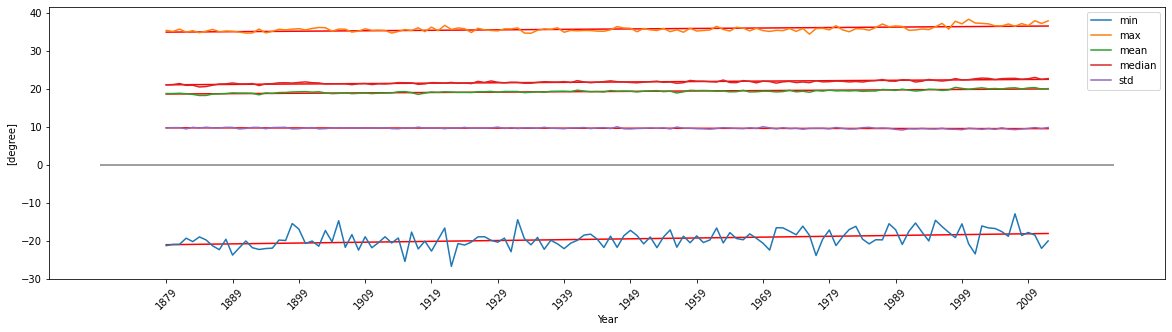

In [ ]:
# get global temperature values 
aggregates = ['min', 'max', 'mean', 'median', 'std']
# filter data
quality_data = filter_data_ext(df_temp,aggregates,"AverageTemperature", list(valid_countries.values), year_to_cut_off, 2013)

# plot data
fig, ax = plt.subplots(figsize=(20,5))
for value in aggregates:
  regressor = calc_linear_coeficient_ext(quality_data, value)
  x1, x2 = year_to_cut_off, 2013
  y1 = x1 * regressor[0] + regressor[1]
  y2 = x2 * regressor[0] + regressor[1]
  print("Average growth of temperature per year based on  __{}__ {}in degree Celsius: {:+4.3f} quality R² = {:+5.4f}".format(value, " "*(6-len(value)), regressor[0], regressor[2]))

  predicted_line = {'Year': [year_to_cut_off,quality_data.Year.max()], value: [y1,y2]}
  index = [0, 1]
  predicted_df = pd.DataFrame(predicted_line, index=index)
  
  sns.lineplot(data=predicted_df, x='Year', y=value, color = "red")
  sns.lineplot(data=quality_data, x='Year', y=value, label=value)

plt.xticks(np.arange(year_to_cut_off, quality_data.Year.max(), step=10), rotation=45)
plt.ylabel('[degree]')
plt.hlines(y=0, xmin=year_to_cut_off-10, xmax=quality_data.Year.max()+10,colors='grey')
plt.show()

In [ ]:
start_year = year_to_cut_off
end_year = 2012
slice_size = 30
coeffs = pd.DataFrame([], columns=['PeriodEnd','a', 'b', 'r2']).set_index('PeriodEnd')

for i in range(end_year - start_year - slice_size+2):    #+1 for index offset +1 for filter-function
  quality_data = filter_data_ext(
      df_temp, 
      "mean", 
      "AverageTemperature",
      list(valid_countries.values),
      start_year + i,
      start_year+i+slice_size)
  regressor = calc_linear_coeficient_ext(quality_data, "mean")
  coeffs.loc[start_year+i+slice_size,'a']=regressor[0]
  coeffs.loc[start_year+i+slice_size,'b']=regressor[1]
  coeffs.loc[start_year+i+slice_size,'r2']=regressor[2]
coeffs.reset_index(inplace=True)
coeffs['PeriodEnd'] = pd.to_numeric(coeffs['PeriodEnd'], downcast='signed')
coeffs['a'] = pd.to_numeric(coeffs['a'], downcast='float')

quality_data = filter_data_ext(
      df_temp, 
      "mean", 
      "AverageTemperature",
      list(valid_countries.values),
      year_to_cut_off,
      2013)


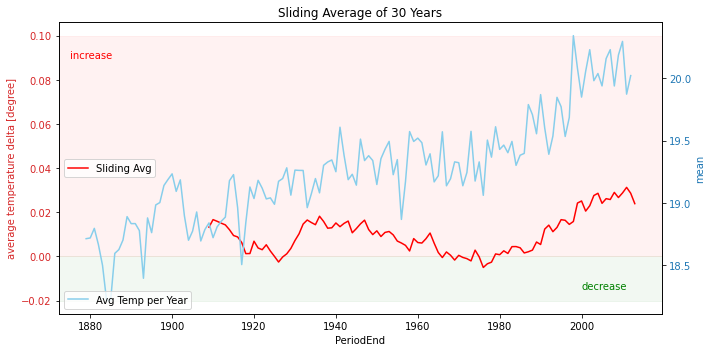

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,5))

color = 'tab:red'
ax1.set_xlabel('time (s)')

sns.lineplot(data=coeffs, x='PeriodEnd', y='a', ax=ax1, color='red', label='Sliding Avg')
ax1.set_ylabel('average temperature delta [degree]', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('mean', color=color)  # we already handled the x-label with ax1
sns.lineplot(data=quality_data, x='Year', y='mean', ax=ax2, color='skyblue', label='Avg Temp per Year')
ax2.tick_params(axis='y', labelcolor=color)

ax1.axhspan(0, 0.1, color='red', alpha=0.05)
ax1.annotate('increase', [1875, 0.09], fontsize=10, color='red')
ax1.axhspan(0, -0.02, color='green', alpha=0.05)
ax1.annotate('decrease', [2000, -0.015], fontsize=10, color='green')

plt.title('Sliding Average of 30 Years')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax1.legend(loc='center left')
ax2.legend(loc='lower left')
plt.show()


**Result for Thesis 1:**

Global warming is  **not**  a myth!


The average temperatur in the world is increasing independend from the method of aggregation.

Only the standard deviation is decreasing. This reflects the increasing quality of provided data.

Best R² value is provided by mean-aggregation, so use it in further steps.



---



---




## Thesis 2: We don't: 
Is global warming caused/accelerated by the technological advance of humans?




**Idea:**


 "Technological advance of humans" is reflected by population:

 * Technological advance allows to feed more human individuals
 * Technological advance increase energy consumption, which increases pollution, which increases global temperature


### Load and Display Population Data

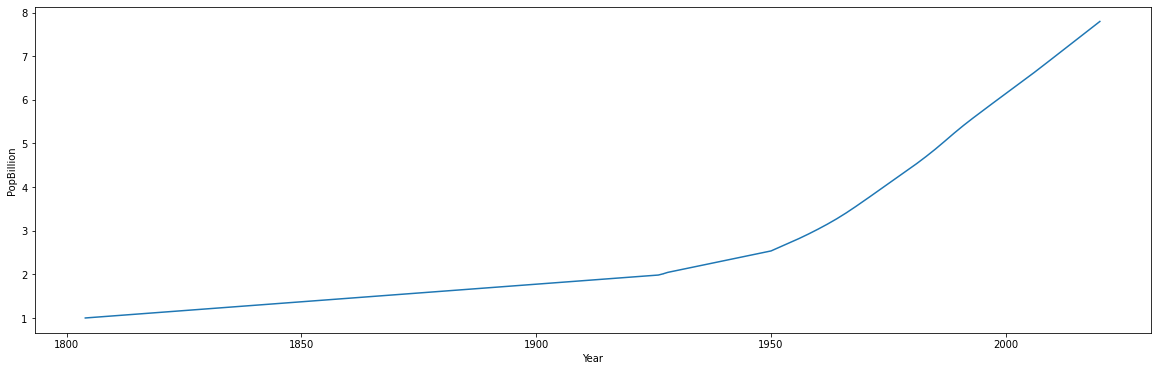

In [ ]:
url = 'https://gist.githubusercontent.com/michalharakal/fc562fc291fb7cdeefb495e3e428aa03/raw/cb2d73aacaa15966fe634bc6b1e5f9a64c01c58f/UNO_WPP.csv'

df_pop = pd.read_csv( url, sep=';')
df_pop['PopBillion'] = pd.to_numeric(df_pop['Population'].str.replace(" ", ""))
df_pop['PopBillion'] /= 1000000.0 

pop_1804 = 1.000000
pop_1927 = 2.000000
pop_1950 = 2.536431

delta1 = ( pop_1927 - pop_1804 ) / (1927 - 1804 + 1)
delta2 = ( pop_1950 - pop_1927 ) / (1950 - 1927 + 1)

pop = pop_1804
for idx, year in enumerate(range(1805, 1927, 1)) :
  pop = pop + delta1
  df_pop = df_pop.append( {'Year': int(year) , 'PopBillion':pop } , ignore_index=True )

pop = pop_1927
for idx, year in enumerate(range(1927, 1950, 1)) :
  pop = pop + delta2
  df_pop = df_pop.append( {'Year': int(year) , 'PopBillion':pop }  , ignore_index=True)

df_pop['Year'] = pd.to_numeric(df_pop['Year'], downcast='signed')

df_pop.sort_values(by='Year',  inplace=True )


plt.subplots(figsize = (20,6))
sns.lineplot(data=df_pop, x='Year', y='PopBillion')
plt.show()

Looking at the graph leads us to the conclusion, that somewhere around 1950 population increased massively. So let's take a look at the gradient since that year in a later step.


### Plot Population and Global Temperature in one Figure


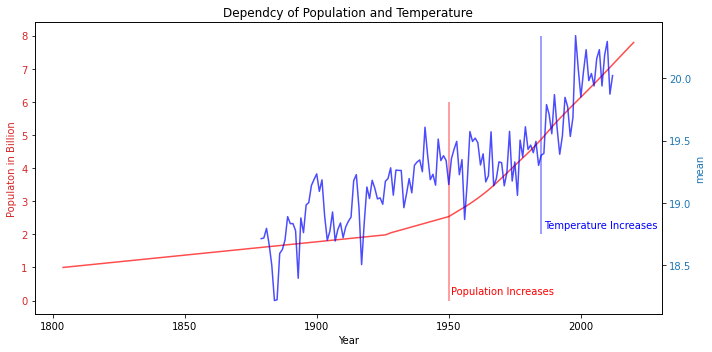

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,5))

color = 'tab:red'
ax1.set_xlabel('time (s)')

sns.lineplot(data=df_pop, x='Year', y='PopBillion',  color='red', alpha=.7)
ax1.set_ylabel('Populaton in Billion', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('mean', color=color)  # we already handled the x-label with ax1
sns.lineplot(data=quality_data, x='Year', y='mean', ax=ax2, color='blue', alpha=.7)
ax2.tick_params(axis='y', labelcolor=color)

ax1.vlines(1950,0,6, color='red', alpha=.5)
ax1.annotate('Population Increases', [1951, .2], fontsize=10, color='red')

ax1.vlines(1985,2,8, color='blue', alpha=.5)
ax1.annotate('Temperature Increases', [1986, 2.2], fontsize=10, color='blue')

plt.title('Dependcy of Population and Temperature')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
#ax1.legend(loc='center left')
#ax2.legend(loc='lower left')
plt.show()

Global temperature follows global population with same delay.

### How Population and Global Temperature Correlated?


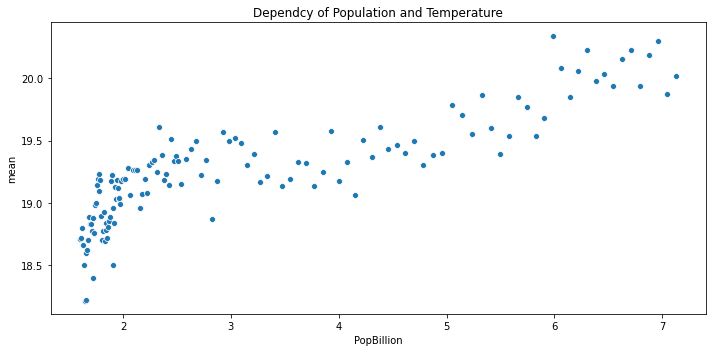

In [ ]:
# merge data sets
df_pop_temp = pd.merge(df_pop, quality_data, how='right', left_on='Year', right_on='Year')

fig, ax1 = plt.subplots(figsize=(10,5))
sns.scatterplot(data=df_pop_temp, x='PopBillion', y='mean')

plt.title('Dependcy of Population and Temperature')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
#ax1.legend(loc='center left')
#ax2.legend(loc='lower left')
plt.show()


### Let's Try some Polynomial Models


linear model: R² = +0.6817
square model: R² = +0.6797
 cubic model: R² = +0.7053


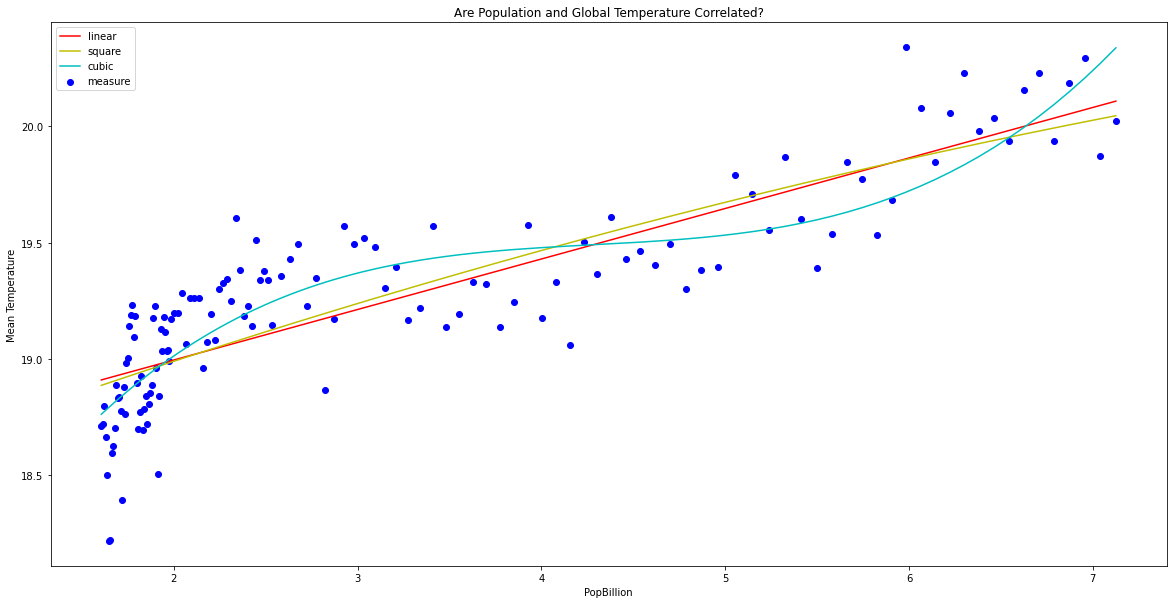

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_pop_temp['PopBillion'], df_pop_temp['mean'], random_state=24, train_size = 0.80)
# # linear model
polymodel1 = np.polyfit( x = X_train, y = y_train, deg = 1 ) 
print("linear model: R² = {:+5.4f}".format(r2_score(y_test, np.poly1d(polymodel1)(X_test))))

# # square model
polymodel2 = np.polyfit( x = X_train, y = y_train, deg = 2 ) 
print("square model: R² = {:+5.4f}".format(r2_score(y_test, np.poly1d(polymodel2)(X_test))))

#cubic model
polymodel3 = np.polyfit( x = X_train, y = y_train, deg = 3 ) 
print(" cubic model: R² = {:+5.4f}".format(r2_score(y_test, np.poly1d(polymodel3)(X_test))))


fig, ax = plt.subplots(figsize=(20,10))
plt.scatter(data=df_pop_temp, x='PopBillion', y='mean', color='b', label='measure')
plt.plot(df_pop_temp.PopBillion, np.poly1d(polymodel1)(df_pop_temp.PopBillion), color='r', label='linear')
plt.plot(df_pop_temp.PopBillion, np.poly1d(polymodel2)(df_pop_temp.PopBillion), color='y', label='square')
plt.plot(df_pop_temp.PopBillion, np.poly1d(polymodel3)(df_pop_temp.PopBillion), color='c', label='cubic')
plt.legend()
plt.xlabel('PopBillion')
plt.ylabel('Mean Temperature')
plt.title('Are Population and Global Temperature Correlated?')
plt.show()

**Result Thesis 2:** 

Based on the assumption that global population is also related to technical advance, technical advance is highly correlated to the global temperature.



---



---




##Thesis 3: Not serious:
Assuming our environment would be in serious trouble when reaching 21°C average global temperature per year, when would this happen?

### Take Cubic Model of Popolation vs. Temperature and solve on 21 degree.

In [ ]:
# a*x**3 + b*x**2 + c*x + d = 0
#
a = polymodel3[0]
b = polymodel3[1]
c = polymodel3[2]
d = polymodel3[3]

pop_threshold = np.real(np.roots([a,b,c,d-21])[0])
print("21 degree limit will be reached, when population has reached {} billion people.".format(round(pop_threshold,3)))


21 degree limit will be reached, when population has reached 7.785 billion people.


### Find Model to Describe Population Development


linear model: R² = +0.7435
square model: R² = +0.9659
 cubic model: R² = +0.9971


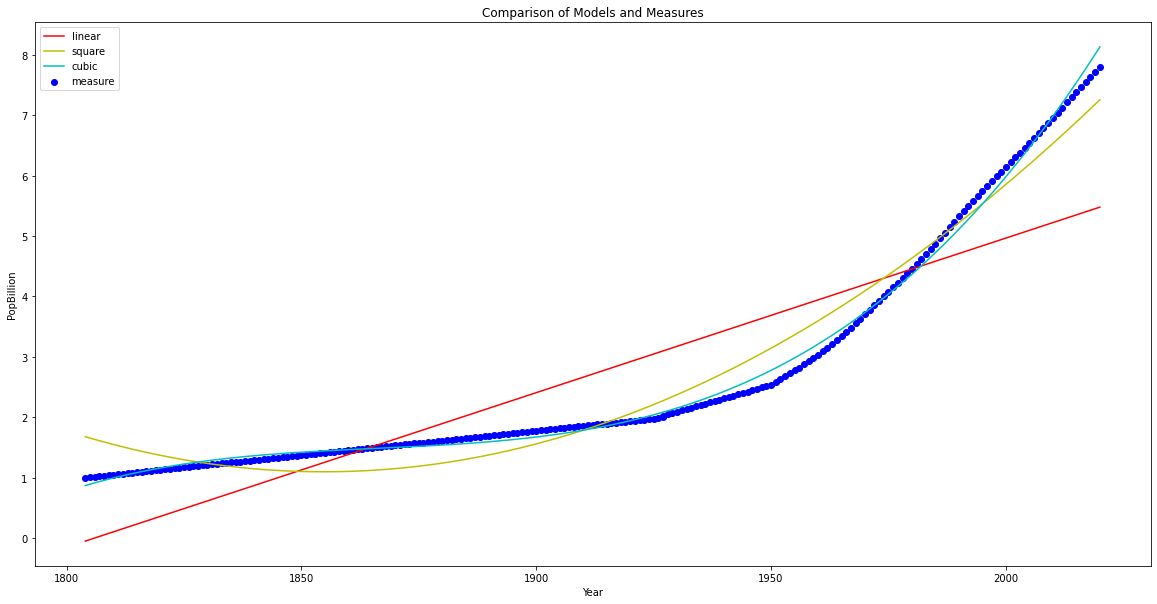

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_pop['Year'], df_pop['PopBillion'], random_state=24, train_size = 0.80)
# linear model
polymodel1 = np.polyfit( x = X_train, y = y_train, deg = 1 ) 
print("linear model: R² = {:+5.4f}".format(r2_score(y_test, np.poly1d(polymodel1)(X_test))))

# square model
polymodel2 = np.polyfit( x = X_train, y = y_train, deg = 2 ) 
print("square model: R² = {:+5.4f}".format(r2_score(y_test, np.poly1d(polymodel2)(X_test))))

#cubic model
polymodel3 = np.polyfit( x = X_train, y = y_train, deg = 3 ) 
print(" cubic model: R² = {:+5.4f}".format(r2_score(y_test, np.poly1d(polymodel3)(X_test))))

fig, ax = plt.subplots(figsize=(20,10))
plt.scatter(data=df_pop, x='Year', y='PopBillion', color='b', label='measure')
plt.plot(df_pop.Year, np.poly1d(polymodel1)(df_pop.Year), color='r', label='linear')
plt.plot(df_pop.Year, np.poly1d(polymodel2)(df_pop.Year), color='y', label='square')
plt.plot(df_pop.Year, np.poly1d(polymodel3)(df_pop.Year), color='c', label='cubic')
plt.legend()
plt.xlabel('Year')
plt.ylabel('PopBillion')
plt.title('Comparison of Models and Measures')
plt.show()

Cubic model fits very good, but square could be better for prediction as growth seems to increase.

In [ ]:
a = polymodel2[0]
b = polymodel2[1]
c = polymodel2[2]

year_21_deg = np.real(np.roots([a,b,c-pop-pop_threshold])[0])
print("Population of {} billion people will be reached {} based on the square model.".format(round(pop_threshold,3), int(year_21_deg)))

a = polymodel3[0]
b = polymodel3[1]
c = polymodel3[2]
d = polymodel3[3]

year_21_deg = np.real(np.roots([a,b,c,d-pop-pop_threshold])[0])
print("Population of {} billion people will be reached {} based on the cubic model.".format(round(pop_threshold,3), int(year_21_deg)))


Population of 7.785 billion people will be reached 2056 based on the square model.
Population of 7.785 billion people will be reached 2036 based on the cubic model.


### Check LR models
y=ax+b leads to x=(y-b)/a with y = 21

Starting regression in 1879 leads to 21 degrees in 2136
Starting regression in 1950 leads to 21 degrees in 2082
Starting regression in 1980 leads to 21 degrees in 2027


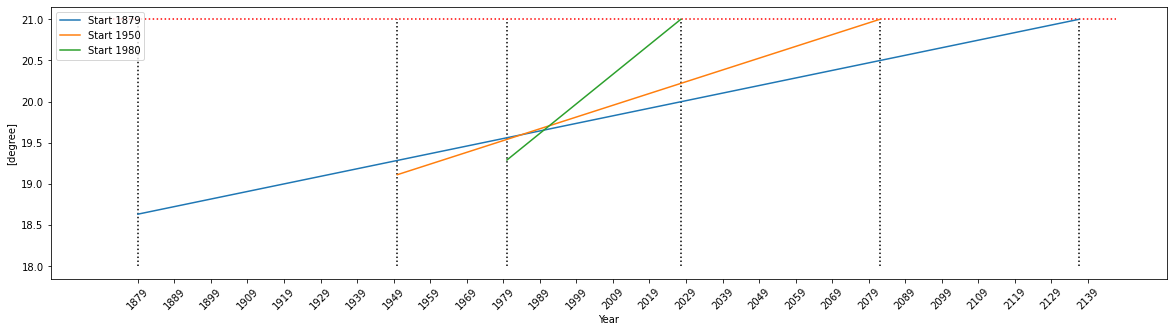

In [ ]:
def predict_year(source_data, start_year, end_year, target_temperature):
  quality_data = filter_data_ext(source_data,"mean","AverageTemperature", list(valid_countries.values),start_year,end_year)
  regressor = calc_linear_coeficient_ext(quality_data, "mean")
  y = target_temperature
  return (y - regressor[1])/regressor[0], regressor[0], regressor[1]
  
last_valid_year = df_temp.Year.max() - 10
evaluated_years = [{"start":year_to_cut_off, "end":last_valid_year},
                   {"start":1950, "end":last_valid_year},
                   {"start":1980, "end":last_valid_year}]  

target_year = 0
fig, ax = plt.subplots(figsize=(20,5))
for year_range in evaluated_years:
  year, coef ,inter  = predict_year(df_temp, year_range["start"],year_range["end"], 21)
  print("Starting regression in {} leads to 21 degrees in {}".format(year_range["start"], int(year)))
  if (year > target_year): target_year = year 
  y1 =  year_range["start"]*coef + inter
  y2 =  year*coef + inter
  
  predicted_line = {'Year': [year_range["start"],year], "Predicted": [y1,y2]}
  index = [0, 1]
  predicted_df = pd.DataFrame(predicted_line, index=index)
  start_year = year_range["start"]
  sns.lineplot(data=predicted_df, x='Year', y="Predicted", label=f"Start {start_year}")
  plt.vlines(x=year, ymin = 18, ymax=21, linestyles="dotted")
  plt.vlines(x=year_range["start"], ymin = 18, ymax=21, linestyles="dotted")


plt.xticks(np.arange(year_to_cut_off, target_year + 10, step=10), rotation=45)
plt.ylabel('[degree]')
plt.hlines(y=21, xmin=year_to_cut_off-10, xmax=target_year+10,colors='red', linestyles="dotted")
plt.show()

Compared to the complex solution using Population, the LR provides quite good results as well.

Starting regression in 1879 leads to 21 degrees in 2136

Starting regression in 1950 leads to 21 degrees in 2082

Starting regression in 1980 leads to 21 degrees in 2027




---



---




## Thesis 4: Not definitive:
Does the data support that global warming will slow down or stop in the future?


**Result: not really in short future without any measures**

As the population seems to converge against a saturation, the curve of global temperature seems to flatten. 

But this seems to happen too slow, to be able to give any forecast





---



---




# Mission 2:
Figure out when Venice will be consumed by the sea

Global sea levels:
https://raw.githubusercontent.com/datasets/sea-level-rise/master/data/epa-sea-level.csv



##Thesis 5: Rise of Sea Levels

Another effect that accompanies global warming is the rise of sea levels. This is of course primarily a problem for people living very close to the sea in very low elevation. Venice lies 3 feet above the current average sea level, how long will it take for the global sea level to rise this far, starting today?


In [ ]:
# feet to inch
Venice = 3
Venice = Venice * 12

### Load and Display Sea Level Data

In [ ]:
url = 'https://raw.githubusercontent.com/datasets/sea-level-rise/master/data/epa-sea-level.csv'
df_sea = pd.read_csv(url)
display(df_investigate(df_sea))


,filled,filled %,nunique,uniques,dtypes
Year,135,100.00,135,NaN,int64
CSIRO Adjusted Sea Level,134,99.26,128,NaN,float64
Lower Error Bound,134,99.26,129,NaN,float64
Upper Error Bound,134,99.26,127,NaN,float64
NOAA Adjusted Sea Level,22,16.30,22,NaN,float64


### Clean Data

In [ ]:
# NOAA column is not helpful
df_sea.drop('NOAA Adjusted Sea Level', axis=1, inplace=True)

# remove NaN
df_sea.dropna(inplace=True)
display(df_sea.head())
display(df_investigate(df_sea))

,Year,CSIRO Adjusted Sea Level,Lower Error Bound,Upper Error Bound
0,1880,0.000000,-0.952756,0.952756
1,1881,0.220472,-0.732283,1.173228
2,1882,-0.440945,-1.346457,0.464567
3,1883,-0.232283,-1.129921,0.665354
4,1884,0.590551,-0.283465,1.464567


,filled,filled %,nunique,uniques,dtypes
Year,134,100.0,134,NaN,int64
CSIRO Adjusted Sea Level,134,100.0,128,NaN,float64
Lower Error Bound,134,100.0,129,NaN,float64
Upper Error Bound,134,100.0,127,NaN,float64


### Plot First View

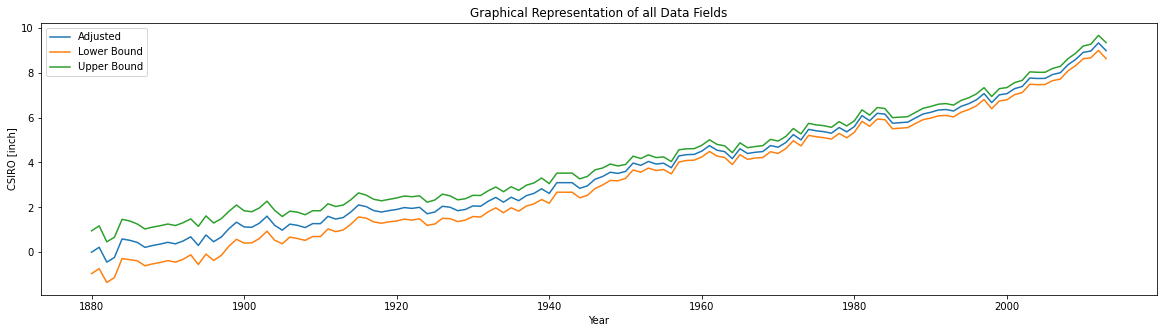

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))
sns.lineplot(data=df_sea, x='Year', y='CSIRO Adjusted Sea Level', label='Adjusted')
sns.lineplot(data=df_sea, x='Year', y='Lower Error Bound', label='Lower Bound')
sns.lineplot(data=df_sea, x='Year', y='Upper Error Bound', label='Upper Bound')
plt.legend()
plt.ylabel('CSIRO [inch]')
plt.title('Graphical Representation of all Data Fields')
plt.show()

Data looks good. Focus on column "CSIRO Adjusted Sea Level".



### Split Data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_sea['Year'], df_sea['CSIRO Adjusted Sea Level'], random_state=24, train_size = 0.80)

### Train and Test some Models

In [ ]:
# linear model
polymodel1 = np.polyfit( x = X_train, y = y_train, deg = 1 ) 
print("linear model: {:+5.4f}".format(r2_score(y_test, np.poly1d(polymodel1)(X_test))))

# square model
polymodel2 = np.polyfit( x = X_train, y = y_train, deg = 2 ) 
print("square model: {:+5.4f}".format(r2_score(y_test, np.poly1d(polymodel2)(X_test))))

#cubic model
polymodel3 = np.polyfit( x = X_train, y = y_train, deg = 3 ) 
print(" cubic model: {:+5.4f}".format(r2_score(y_test, np.poly1d(polymodel3)(X_test))))

linear model: +0.9671
square model: +0.9876
 cubic model: +0.9893


### Plot Results

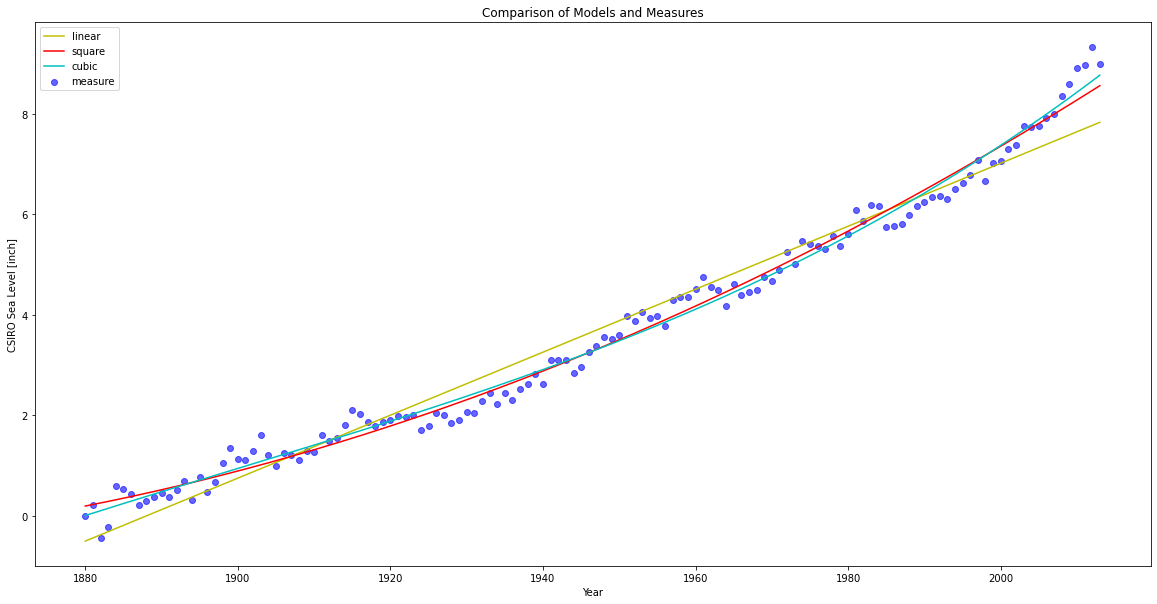

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
plt.scatter(data=df_sea, x='Year', y='CSIRO Adjusted Sea Level', color='b', label='measure', alpha=.6)
plt.plot(df_sea.Year, np.poly1d(polymodel1)(df_sea.Year), color='y', label='linear')
plt.plot(df_sea.Year, np.poly1d(polymodel2)(df_sea.Year), color='r', label='square')
plt.plot(df_sea.Year, np.poly1d(polymodel3)(df_sea.Year), color='c', label='cubic')
plt.legend()
plt.xlabel('Year')
plt.ylabel('CSIRO Sea Level [inch]')
plt.title('Comparison of Models and Measures')
plt.show()

Cubic model fits best, but square is easier to calculate by hand. 


In [ ]:
# let's calulate on square basis:
# y = ax²+bx+c
# 0 = ax²+bx+c-y
# 0 = x²+(b/a)x+(c-y)/a
# p = b/a
# q = (c-y)/a
# x1 = -p/2+sqr((p/2)²-q)
# x1 = -p/2+sqr((p/2)²-q)
a = polymodel2[0]
b = polymodel2[1]
c = polymodel2[2]
p = b/a
q = (c-Venice)/a
x1 = -p/2+np.sqrt((p/2)**2-q)
#x2 = -p/2-np.sqrt((p/2)**2-q)
print("Based on a square polynomial model, Venice will sink in " + str(int(x1)))
#np.roots([a,b,c-Venice])


a = polymodel3[0]
b = polymodel3[1]
c = polymodel3[2]
d = polymodel3[3]

x1_cub = np.real(np.roots([a,b,c, d-Venice])[0])
print("Based on a cubic polynomial model, Venice will sink in " + str(int(x1_cub)))


Based on a square polynomial model, Venice will sink in 2204
Based on a cubic polynomial model, Venice will sink in 2137


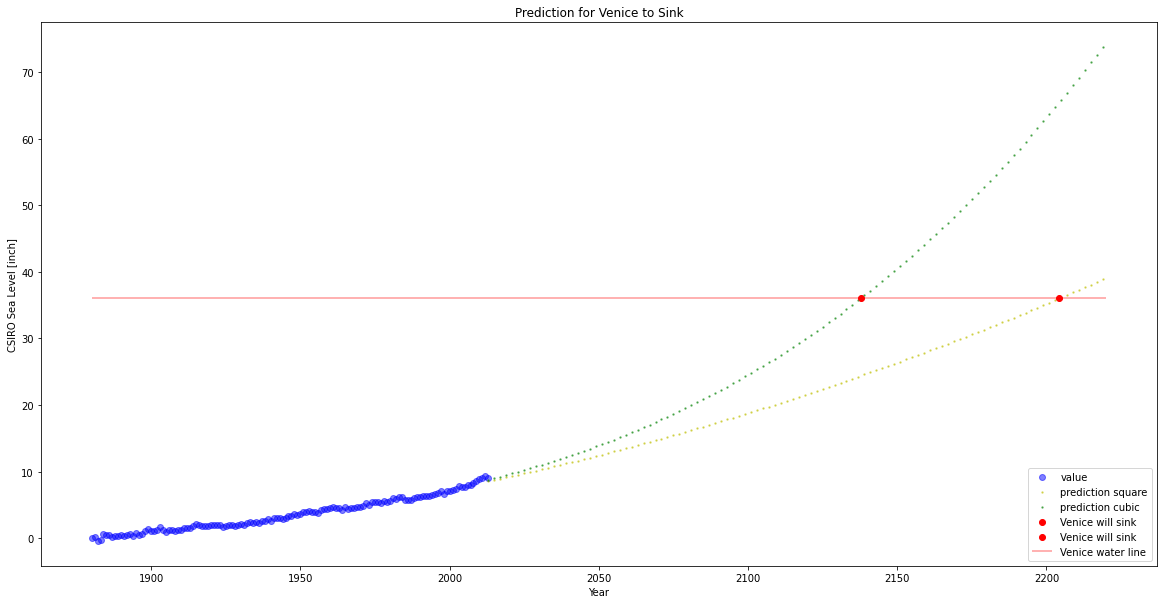

In [ ]:
future = np.arange(2013, 2220, 2).tolist()

fig, ax = plt.subplots(figsize=(20,10))
plt.scatter(data=df_sea, x='Year', y='CSIRO Adjusted Sea Level', color='b', label='value', alpha=.5)
plt.scatter(future, np.poly1d(polymodel2)(future), color='y', label='prediction square',alpha=.5, s=2)
plt.scatter(future, np.poly1d(polymodel3)(future), color='g', label='prediction cubic',alpha=.5, s=2)
plt.scatter(x1, np.poly1d(polymodel2)(x1), color='r', label='Venice will sink')
plt.scatter(x1_cub, np.poly1d(polymodel3)(x1_cub), color='r', label='Venice will sink')
plt.hlines(Venice,df_sea.Year.min(), 2220, color='r', label='Venice water line', alpha=.4)

plt.legend(loc='lower right')
plt.xlabel('Year')
plt.ylabel('CSIRO Sea Level [inch]')

plt.title('Prediction for Venice to Sink')
plt.show()



---



---




# Mission 3:
Prepare a 15 min presentation on your findings




# Mission 4:
The presentation should contain evidence to support your arguments accompanied by hard data




# Mission 5:
Provide a link to a notebook containing your analysis and any work you did to help you answer these questions.





# Mission 6:
Use one or more models to predict how the variables at stake here will perform in the future.








# Hints
If you don’t know at all where to start, here are a few hints for your consideration.

* Stick to the temperature dataframe at first, to keep things simple
* After getting a decent overview of the types of values, consider a few plots
* Since there are many cities in this record it might be beneficial to aggregate the temperatures appropriately
* For treating datetime series in pandas, check out the documentation
* Even if we are predicting temperatures over years/months, linear models do not care weather 1850 describes a year, or is simply the integer between 1.849 and 1.851
